# Imports

In [1]:
import numpy as np                                                              # Linear Algebra

import pandas as pd                                                             # Data Processing
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import datetime as dt                                                           # DateTime Manipulation

from geopy.distance import great_circle, vincenty                               # geospatial manipulations
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN

%matplotlib inline
import matplotlib.pyplot as plt                                                 # visualizations
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split as tts                     # data splitting


import category_encoders as ce                                                  # preprocessing
from sklearn.impute import SimpleImputer                                        
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegression           # models
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import make_pipeline                                      # pipeline engineering

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV            # hyperparameter tuning

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error   # model scoring



import datetime as dt

C:\Users\btros\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Functions

In [2]:
def reduce_features(df):
    cols = ['X', 'Y', 'incident_id']
    
    df = df.drop(columns=cols)
    
    return df

def drop_null_cols(df):
    
    columns_with_null = df.isnull().sum().sort_values(ascending=False)[:9].index.tolist()
    df = df.drop(columns=columns_with_null)
    
    return df

def extract_timestamp_feats(df, column='call_timestamp'):
    
    # Cast the column to DateTime type
    df[column] = pd.to_datetime(df[column])
    
    # Extract date related features
    df['year']  = df[column].dt.year
    df['month'] = df[column].dt.month
    df['day']   = df[column].dt.day
    df['dow']   = df[column].dt.dayofweek
    df['week']  = df[column].dt.week
    
    # Extract time related features
    df['hour']   = df[column].dt.hour
    """
    Extacts the time of day from the hour value by dividing by the hour knife
    1 = Morning  (0400 - 1000h)
    2 = Midday   (1000 - 1600h)
    3 = Evening  (1600 - 2200h)
    4 = Night    (2200 - 0400h)
    """    
    hour_knife = 6
    df['part_of_day'] = ((df['hour'] + 2) / hour_knife).astype(int)
    df['part_of_day'] = df['part_of_day'].replace(0, 4)
    
    # Drop the now redundant column
    df = df.drop(columns=column)
    
    return df

def filter_geo_outliers(df):
    """
    Filters out the outliers in the data where the latitude and longitudes 
    exist outside the geographic limits of the city of Detroit
    """    
    n_bound =  42.46
    e_bound = -82.91
    s_bound =  42.25
    w_bound = -83.28
    
    #  Retains only those observations within the geographic boundaries
    df = df.loc[((df['longitude'] > w_bound) & (df['longitude'] < e_bound)) &
                ((df['latitude'] > s_bound) & (df['latitude'] < n_bound ))]
    
    return df 

def plot_lat_lon(df):
    
    fig, ax = plt.subplots(figsize=(12, 8))
#     img = plt.imread(r"C:\Users\btros\Downloads\detroit_map.jpg")
#     ax.imshow(img)
    ax = sns.scatterplot(data=df, x='longitude', y='latitude', alpha=0.1)
#     ax = sns.scatterplot(x=[1,2,3], y=[2,4,6], alpha=0.1)
    ax.set_facecolor('.2')
    fig.set_facecolor('.2')
    
    return plt.show();

def remove_categoricals(df):
    unneeded = df.select_dtypes(exclude="number").nunique().index.tolist()
    unneeded.remove('calldescription')

    df = df.drop(columns=unneeded)
    
    return df

def clean_observations(df):    
    """
    Removing observations where the call description
    is not related to emergency services
    """
    col = 'calldescription'
    
    unrelated_calls = ['START OF SHIFT INFORMATION', 'CALL BACK DESK', 'REMARKS',
                      'EMPLOYEE CALL IN / TIME OFF', 'NOTIFICATION(S) MADE',
                      'TIBURON HISTORICAL DATE', 'BLUE LIGHT PHONE MALF']
    
    for call in unrelated_calls:
        df = df.loc[df[col] != call]
    
    return df

def filter_calldescription(df, col='calldescription'):
    
    #  List of call descriptions according to which service responded
    
    police = ['TRAFFIC STOP', 'SPECIAL ATTENTION', 'DISTURBANCE', 'INVESTIGATE PERSON',
              'ASSAULT AND BATTERY', 'UNKNOWN PROBLEM', 'TOWING DETAIL', 'FELONIOUS ASSAULT IP',
              'LARCENY REPORT', 'AUTO X UNK INJ / IMPAIRED', 'BUS BOARDING', 'PERSON WITH WEAPON',
              'VERIFIED ALR / PERSON W/O CODE', 'UDAA REPORT', 'BURGLARY OCCUPIED RESD I/P',
              'SHOTS FIRED IP', 'INVESTIGATE AUTO', 'MALICIOUS DESTRUCTION I/P', 'MISCELLANEOUS TRAFFIC',
              'PANIC / DURESS ALARM', 'FRAUD REPORT', 'BUILDING CHECK', 'VICIOUS ANIMAL', 'LARCENY I/P OR J/H',
              'THREATS REPORT', 'RECOVER AUTO', 'HOLD UP ALARM AND MOW', 'MALICIOUS DESTRUCTION RPT', 
              'BURGLARY OTHER', 'PARKING COMPLAINT', 'WELL BEING CHECK', 'MENTAL VIOLENT NOT ARMED',
              'ASSIST OTHER', 'INFORMATION/NON-CRIMINAL RPT', 'ASSAULT AND BATTERY REPORT', 'AUTO X REPORT',
              'BURGLARY OCCUPANT AWAY I/P', 'MISSING REPORT',  'NARCOTICS I/P', 'BURGLARY RESIDENCE REPORT',
              'MISSING SERIOUS', 'ALARM UNKNOWN CAUSE', 'SUICIDE THREAT', 'CHILD /  ADULT ABUSE',  'WNTD WRRNT FELONY',
              'ADMIT OR E/E', 'FELONIOUS ASSAULT JH', 'ASSIST CITIZEN', 'SPECIAL ATTENTION / DETAIL', 'DEAD PERSON OBSERVED',
              'LOST PROPERTY', 'SUICIDE I/P', 'TRANSPORT PRISONER', 'ROBBERY ARMED IP-ANY', 'RECOVERED / FOUND PROPERTY',
              'SAFEWALK', 'CHILD / ADULT ABUSE REPORT', 'BREAKING AND ENTERING AUTO I/P', 'FELONIOUS ASSAULT REPORT',
              'RAID - EXECUTE SEARCH WARRANT', 'MENTAL VIOLENT - ARMED', 'RAPE REPORT', 'HARASSMENT REPORT',
              'BURGLARY BUSINESS IP', 'KIDNAPPING', 'PPO VIOLATION I/P', 'LEWD AND LASCIVIOUS IP', 'AID MOTORIST / CHILD LOCKED IN',
              'BREAKING & ENTERING AUTO RPT', 'DV A/B I/P-J/H', 'ROBBERY NOT ARMED I/P', 'SQUATTER DISTURBANCE',
              'SCRAP STRIP  BLDG  IP', 'ASSAULT AND BATTERY I/P', 'AUTO OR PED H&R REPORT', 'FRAUD I/P',
              'AUTO X HIT & RUN W/ INJ', 'BURGLARY OCCUP RESD REPT', 'RUBBISH LITTERING I/P', 'SHOTS J/H, EVIDENCE, REPT',
              'BE ON THE LOOK OUT', 'SHOOTING/CUTTING/PENT WND RPT', 'HOLDING PERSON', 'ARSON I/P', 'BURGLARY OTHER REPORT',
              'ANIMAL COMPLAINT', 'ARSON REPORT', 'ASSIST PERSONNEL', 'ROBBERY ARMED REPORT', 'VERIFY RETURN OF MISSING',
              'DDOT TROUBLE', 'WNTD WRRNT MISDEMEANOR', 'ROBBERY ARMED JH-ANY WEAPON',  'BURGLARY OCCUPANT AWAY J/H',
              'UDAA I/P', 'SCHOOL CROSSING', 'HAZARDOUS CONDITIONS', 'SENIOR CITIZEN ASSIST', 'ROBBERY NOT ARMED REPORT',
              'ONE OVER THE WHEEL', 'RAPE IP OR JH', 'PROPERTY DAMAGE NON-CRIMINAL', 'PEACE OFFICER DETAIL', 'BURGLARY BUSINESS REPORT',
              'BURGLARY BUSINESS J/H', 'CHILD(REN) HOME ALONE', 'DV F/A I/P-J/H', 'ESCORT', 'NARCOTICS REPORT', 'AID MOTORIST MISC',
              'PPO VIOLATION REPORT', 'RECOVER AUTO FELONY', 'LEWD AND LASCIVIOUS','VEHICLE FIRE', 'NOISE COMPLAINT', 
              'FOUND PERSON', 'MOLESTATION REPORT', 'PBT TEST', 'RESIDENTIAL STRUCTURE FIRE', 'ASSIST REF GAINING ENTRY',
              'ATM  ALARM',  'WSPD - BURGLARY ALR', 'ALTERED LOC OR UNK PROBLEM', 'PAST GUNSHOT OR STABBINIG', 'AID MORTORIST MISC',
              'BOMB THREAT REPORT',  'ASSAULT  NOT DANGEROUS OR PREV', 'WRKABLE ARRST/OBV OR EXP DEATH',
              'CITIZEN RADIO PATROL IN TROUBL', 'SCHOOL THREATS J/H & RPT', 'TRAFFIC W/ NO INJURIES',  'MISCELLANEOUS ACCIDENT',
              'MOLESTATION', 'BANK ALARM','KIDNAPPING REPORT', 'K-9 DEPLOYMENT', 'SUSPICIOUS PACKAGE', 'DPDA', 
              'WSPD - BURGLARY ALARM', 'VIP THREATS I/P', 'PERSON W/  A WEAPON REPORT', 'AID MOTORIST CHILD LOCKED INSD',
              'ANIMAL FIGHT', 'BOMB THREAT', 'PERSONNEL IN TROUBLE', 'BURGLARY ALARM', 'DV PRS WITH A WEAP I/P-J/H',
              'ASSAULT AND BATTERY J/H', 'AUTO X - BLDG / DWELL', 'PURSUIT - VEHICLE OR FOOT', 'BACKGROUND/LEIN CHK / LIVESCAN',
              'INVESTIGATE YOUTH(S)', 'SHOT STABBED UNK OR OBV DEATH', 'SCRAP STRIP BLDG JH', 'TRANSPORT PRISONER-OTH AGT', 'BOMB SCARE',
              'SMOKING VIOLATIONS', 'DV A/B RPT', 'HPPD BURG ALRM', 'EXTORTION IP', 'EXTORTION JH OR REPORT',
              'OTHR OUTSIDE STRUCTURE FIRE', 'ATTEMPTED SUICIDE REPORT', 'VIP THREATS J/H OR REPORT', 'ASSAULT DANGEROUSOR SERIOUS',
              'TRAFFIC- MINOR INJURIES', 'SUICIDE THREAT OR ABNORM BEHAV', 'BURGLARY ALARM  W/ MOW', 'HPPD BURG ALRM  W/ MOW',
              'BACKGROUND CHECK / LIVESCAN', 'DV F/A RPT', 'CURFEW VIOLATION', 'YOUTH LOITERING/CONGREGATING']

    ems = ['ONE DOWN OR OVER THE WHEEL', 'AUTO X OR PED X - INJURIES', 'AUTO X HIT& RUN UNK INJURIES',
           'MENTAL VIOLENT NOT ARMED', 'MENTAL NOT VIOLENT', 'SHOOTING/CUTTING/PENT WOUND', 'MT EMS-TRO/ENTRY',
           'ONE DOWN/DRUG OD', 'ANIMAL BITES OR ATTACK DELTA', 'SHOT OR STABBED DELTA', 'PREGNANCY OR CHILDBIRTH DELTA',
           'CHEST PAIN DELTA', 'ATYPICAL SEIZURE OR HX OR CVA', 'OB HEMORRHAGE LABOR OR BIRTH',
           'CHEST PAIN NORMAL BREATHING', 'INJURY NON DANGEROUS BODY PART', 'NON SUICIDAL OR NT THRTENING',
           'SICK PERSON DELTA', 'ANIMAL BITE OR ATTACK DELTA', 'FALL W SERIOUS HEMORRHAGE', 'CONT OR MULTI SEIZURES DELTA',
           'PORTABLE ALARM SYSTEM', 'FAINTING ALERT', 'SERIOUS HEMORRHAGE', 'BURNS DELTA  OR ECHO', 'HEADACHE - ADDITIONAL SYMPTONS',
           'NON RECENT OR SUPERFICIAL BITE', 'ASSAULT OR SEX ASSAULT DELTA', 'UNCONSCIOUS OR FAINTING DELTA', 'DV PRSN WITH WEAP RPT',
           'SCHOOL THREATS I/P', 'SICK NON PRIORITY COMPLAINTS', 'SUICIDE ATTEMPT DELTA', 'DANGEROUS HEMORRHAGE DELTA',
           'SERIOUS INJURIES', 'MINOR HEMORRHAGE', 'BREATHING PROBLEMS DELTA', 'CHEST PAIN W OR WO NOR BRETH', 'OVERDOSE DELTA',
           'OVER THE WHEEL',  'TRAFFIC INCIDENT W/ INJURIES', 'POSS DANGEROUS ANIMAL BITE', 'ONE DOWN/OVERDOSE',
           'MAJOR TRAFFIC INCIDENT DELTA', 'OVERDOSE NT ALRT OR UNK STATUS', 'MEDICAL ALARM OR UNK PROB','LIFE STATUS QUESTIONABLE DELTA']

    fire = ['FIRE ALARM TEST', 'FIRE ALARM', 'TEMPERATURE ALARM',  'ELEVATOR ENTRAPMENT', 'VEHICLE FIRE(FIELD)',
            'IRRADIATOR ROOM ALARM / TEST', 'HAZARD CONDITIONS NO FIRE', 'GRASS  FIRE', 'POWER LINES', 'ALR PT DISABLED / TIMEZONE CHG',
            'EXPLOSION/RUPTURE NO FIRE', 'ALARM MALFUNCTION',  'COMMERCIAL STRUCTURE FIRE', 'EXPLOSION',  'FIRE ALARMS ALL',
            'WEATHER RELATED', 'GRASS OR RUBBISH FIRE',  'SMOKE INVESTIGATION', 'WSPD - FIRES', 'ALARM MISUSE']
    
           
    df['police'] = np.where(df[col].isin(police), 1, 0)
    df['ems'] = np.where(df[col].isin(ems), 2, 0)
    df['fire'] = np.where(df[col].isin(fire), 3, 0)
    
    df['category'] = df['fire'] + df['ems'] + df['police']
    df['category'] = df['category'].replace(0, 1)  #  For some reason the Assault and Battery instances are not picked up
    
    
    defunct = ['police', 'ems', 'fire', col]
    
     #  Drop the no longer needed columns

    df = df.drop(columns=defunct)

    return df

def police_only(df):
    # Retains only those observations which contain calls for police assistance
    df = df.loc[df.category == 1]
    df = df.drop(columns='category')
    
    return df

def apply_geospatial_grid(df):
    lat = 'latitude'
    lon = 'longitude'
    # episolon is used to avoid assigning locations outside the grid
    epsilon = .0001
    
    # min and max of latitude and longitude
    lat_min = df[lat].min() - epsilon
    lat_max = df[lat].max() + epsilon
    
    lon_min = df[lon].min() - epsilon
    lon_max = df[lon].max() + epsilon
    
    # ranges
    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min
    
    # splits
    lat_knife = 10
    lon_knife = 15 
    
    # grid lengths
    lon_length = lon_range / lon_knife
    lat_length = lat_range / lat_knife
    
    # assigining the locations to a grid space
    
    df['lat_grid'] = (np.floor(((df[lat]-lat_min)/lat_length)))
    df['lon_grid'] = (np.floor(((df[lon]-lon_min)/lon_length)))
    
    
    # discard the now unneeded columns
    cols = [lat, lon]
    df = df.drop(columns=cols)
    
    return df

def to_heatmap_format(df):
    grid_df = df.groupby(['lat_grid','lon_grid']).size().reset_index(name='call_count')
    geoheatmap_df = grid_fg.pivot(index='lat_grid',columns='lon_grid', values='call_count')
    
    return geoheatmap_df

def plot_calls_grid(df):
    fig, ax = plt.subplots(figsize=(20,8))
    plt.title("Detroit 911 Calls by Geographic Location Halloween 2018",
             fontsize=24)

    ax = sns.heatmap(df,annot=True,fmt=".0f",cbar=False)

    # ax.set_ylim(len('lat_grid'), -1, -1)

    fig.set_facecolor('.1')
    ax.set_facecolor('.1')


    ax.invert_yaxis()
    
    return plt.show();

def group_features(df):
    # groups the dataframe by various DateTime params
    grouping_list = list(df.columns)
    grouping_list.remove('oid')
    grouping_list.remove('hour')
    grouped_df    = df.groupby(grouping_list).size().reset_index(name='count')
    
    return grouped_df


def wrangle(df):
    
    df = reduce_features(df)
    df = drop_null_cols(df)
    df = extract_timestamp_feats(df)
    df = filter_geo_outliers(df)
    df = remove_categoricals(df)
    df = clean_observations(df)
    df = filter_calldescription(df)
    df = police_only(df)
    df = apply_geospatial_grid(df)
    df = group_features(df)
    
    return df 

# Load Data

In [3]:
PATH = r"C:\\Users\\btros\\OneDrive\\Documents\\LSDS-Unit-2-Project\\raw_csvs"

file = r"\\911_Calls_for_Service.csv"

calls = pd.read_csv(PATH+file, low_memory=False)

#  Don't forget to make a copy 

df_copy = calls

In [4]:
calls.columns

Index(['X', 'Y', 'incident_id', 'agency', 'incident_address', 'zip_code', 'priority', 'callcode', 'calldescription', 'category', 'call_timestamp', 'precinct_sca', 'respondingunit', 'officerinitiated', 'intaketime', 'dispatchtime', 'traveltime', 'totalresponsetime', 'time_on_scene', 'totaltime', 'neighborhood', 'block_id', 'council_district', 'longitude', 'latitude', 'oid'], dtype='object')

In [5]:
weather_file = r'\\detroit_weather_wrangled.csv'

weather = pd.read_csv(PATH+weather_file)

weather_copy = weather

In [6]:
weather = weather.drop(columns='Unnamed: 0')

In [7]:
holidays = pd.read_csv(PATH+r'\holidays.csv')

In [8]:
calls = wrangle(calls)

In [9]:
calls

,year,month,day,dow,week,part_of_day,lat_grid,lon_grid,count
0,2016,9,20,1,38,1,5.0,3.0,1
1,2016,9,20,1,38,1,5.0,4.0,1
2,2016,9,20,1,38,1,5.0,9.0,1
3,2016,9,20,1,38,1,7.0,3.0,1
4,2016,9,20,1,38,1,7.0,11.0,1
...,...,...,...,...,...,...,...,...,...
391832,2019,11,15,4,46,4,9.0,7.0,1
391833,2019,11,15,4,46,4,9.0,8.0,1
391834,2019,11,15,4,46,4,9.0,9.0,1
391835,2019,11,15,4,46,4,9.0,10.0,1


In [10]:
weather

,year,month,day,part_of_day,weather_id,severe,temp_min,temp_max
0,2016,8,31,3,800.000000,0.0,66.704000,73.499000
1,2016,8,31,4,800.000000,0.0,62.600000,71.501000
2,2016,9,1,1,801.666667,0.0,59.300000,66.092000
3,2016,9,1,2,651.166667,0.0,67.444747,72.874747
4,2016,9,1,3,606.833333,0.0,66.117594,71.118594
...,...,...,...,...,...,...,...,...
4677,2019,11,13,4,801.166667,0.0,9.566009,19.202000
4678,2019,11,14,1,684.833333,0.0,22.964000,28.865000
4679,2019,11,14,2,635.000000,0.0,28.331000,33.167000
4680,2019,11,14,3,632.600000,0.0,28.756400,33.958400


In [11]:
holidays = holidays.drop(columns='Unnamed: 0')

In [12]:
holidays

,year,month,day,is_holiday
0,2016,10,31,1
1,2016,11,24,1
2,2016,12,26,1
3,2016,12,30,1
4,2017,1,2,1
5,2017,1,16,1
6,2017,2,5,1
7,2017,2,20,1
8,2017,3,17,1
9,2017,4,14,1


In [13]:
merged = pd.merge(calls, weather, how='inner', on=['year', 'month', 'day', 'part_of_day'])

In [15]:
merged2 = pd.merge(merged, holidays, how='left', on=['year', 'month', 'day'])

In [16]:
merged2.is_holiday = merged2.is_holiday.replace(np.NaN, 0)

In [24]:
merged.to_csv('call_grid_with_weather.csv')

In [17]:
## take a quick peak 
merged2.head(1)

,year,month,day,dow,week,part_of_day,lat_grid,lon_grid,count,weather_id,severe,temp_min,temp_max,is_holiday
0,2016,9,20,1,38,1,5.0,3.0,1,800.5,0.0,61.661,70.169,0.0


In [44]:
# then wrangle the data so we can start where we left off on the previous notebook
df = df_copy
df = wrangle(df)

In [10]:
df.head()

,call_year,call_month,call_day,call_dow,call_week,call_minute,part_of_day,lat_grid,lon_grid,count
0,2016,9,20,1,38,0,2,5.0,2.0,1
1,2016,9,20,1,38,0,2,5.0,8.0,1
2,2016,9,20,1,38,0,2,6.0,3.0,1
3,2016,9,20,1,38,0,2,8.0,9.0,1
4,2016,9,20,1,38,0,3,4.0,11.0,1


In [17]:
df.tail()

,call_year,call_month,call_day,call_dow,call_week,call_minute,part_of_day,lat_grid,lon_grid,count
1269749,2019,1,1,1,1,58,4,5.0,3.0,1
1269750,2019,1,1,1,1,58,4,7.0,6.0,1
1269751,2019,1,1,1,1,58,4,8.0,4.0,2
1269752,2019,1,1,1,1,59,4,6.0,6.0,1
1269753,2019,1,1,1,1,59,4,7.0,6.0,1


# Training and Validation Splits, Feature Selection

In [16]:
int(len(df)*.8)

df.iloc[1015803]

call_year      2018.0
call_month        8.0
call_day         10.0
call_dow          4.0
call_week        32.0
call_minute       7.0
part_of_day       4.0
lat_grid          6.0
lon_grid          3.0
count             1.0
Name: 1015803, dtype: float64

In [18]:
train = merged2.loc[((merged2.year < 2019) | ((merged2.year == 2019) & (merged2.month < 8)))]
len(train)

354160

In [19]:
val = merged2.loc[((merged2.year == 2019) & (merged2.month >= 8))]
len(val)

37952

In [20]:
len(val) / len(train)

0.1071606053761012

In [21]:
target   = 'count'
features = merged2.columns.tolist()
features.remove(target)

X_train = train[features]
X_val   = val[features]

y_train = train[target]
y_val   = val[target]

# First model
Let's go with a simple linear regression model on the first run through

In [78]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
y_train_pred = model.predict(X_train)

### Initial model grouped data by call_minute which was a mistake
My initial hypotheses however is that the combination of a low r-squared value
coupled with low train and testing errors is due to the fact that the datetime values inherently
contain little variance and that the geographic trends are so strong that they overcome this 
failure of the model to explain variance

# Without weather data

In [36]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 0.13
R-Squared Score: 1.13%
RMSE: 0.28


In [39]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 0.15
R-Squared Score: 0.76%
RMSE: 0.30


# With Weather Data

In [36]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 2.94
R-Squared Score: 5.86%
RMSE: 4.50


In [37]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 3.48
R-Squared Score: 5.31%
RMSE: 5.14


# With Holidays flagged

In [44]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 2.94
R-Squared Score: 5.87%
RMSE: 4.50


In [45]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 3.48
R-Squared Score: 5.33%
RMSE: 5.14


In [79]:
model.score(X_val, y_val)

0.05327898943122356

In [80]:
train_base, val_base = calc_accuracy_score(y_train), calc_accuracy_score(y_val)

print(f"Training model baseline accuracy: {(train_base)*100:,.2f}%" + "\n")
print(f"Validation model baseline accuracy: {(val_base)*100:,.2f}%")

Training model baseline accuracy: 19.84%

Validation model baseline accuracy: 16.96%


# Logistic Regression with Weather Only

In [46]:
model = LogisticRegression(solver='lbfgs', max_iter=300, multi_class='auto')

model.fit(X_train, y_train)

C:\Users\btros\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
y_train_pred = model.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 3.62
R-Squared Score: -60.23%
RMSE: 5.87


In [86]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 4.43
R-Squared Score: -70.04%
RMSE: 6.88


In [77]:
model.score(X_val, y_val)

0.16961819351420895

# Holidays Flagged

In [47]:
y_train_pred = model.predict(X_train)

mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 3.72
R-Squared Score: -64.35%
RMSE: 5.94


In [48]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 4.52
R-Squared Score: -73.22%
RMSE: 6.95


In [73]:
model.score(X_val, y_val)

0.16961819351420895

In [67]:
base = [y_val.value_counts().index[0]] * len(y_val)

In [69]:
mse = mean_squared_error(y_val, base)
mse

48.26001816324214

In [75]:

def calc_accuracy_score(target_feature):
  majority_class = target_feature.mode()[0]               #   Find the mode of the target feature
  target_pred = [majority_class] * len(target_feature)    #   Create a list the length of the target feature with consisting of the mode as the sole value

  score = accuracy_score(target_feature, target_pred)     

  return score

In [76]:
train_base, val_base = calc_accuracy_score(y_train), calc_accuracy_score(y_val)

print(f"Training model baseline accuracy: {(train_base)*100:,.2f}%" + "\n")
print(f"Validation model baseline accuracy: {(val_base)*100:,.2f}%")

Training model baseline accuracy: 19.84%

Validation model baseline accuracy: 16.96%


### Grouping by call_minute error fixed 
Metrics still seem to support my initial hypothesis however we will try some different models and see what happens

In [51]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 2.95
R-Squared Score: 5.63%
RMSE: 4.50


In [52]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 3.51
R-Squared Score: 5.36%
RMSE: 5.14


In [53]:
y_val.value_counts()

1     8987
2     7662
3     6642
4     5699
5     4881
6     3981
7     3161
8     2395
9     1853
10    1420
11    1099
12     870
13     633
14     538
15     409
16     354
17     267
18     259
19     229
20     197
21     146
22     138
23     134
24     118
25     112
26      88
27      86
28      71
29      62
30      60
32      51
33      40
31      38
34      31
35      22
38      20
36      20
41      15
39      15
37      13
40      11
42       8
43       6
47       4
44       4
46       3
45       3
54       3
50       2
51       2
52       2
58       2
49       1
66       1
Name: count, dtype: int64

In [54]:
len(y_val == y_val_pred)

52868

# Decision Tree Regressor

In [38]:
model = DecisionTreeRegressor()

In [39]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

In [61]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 0.00
R-Squared Score: 100.00%
RMSE: 0.00


In [62]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 3.02
R-Squared Score: 27.28%
RMSE: 4.50


# With Weather Data

In [40]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 0.00
R-Squared Score: 100.00%
RMSE: 0.00


In [41]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 3.04
R-Squared Score: 27.58%
RMSE: 4.49


# Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1)

In [24]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

## Default estimators

In [66]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

print(model.score(X_val, y_val))

Train Error: 0.75
R-Squared Score: 93.91%
RMSE: 1.14


In [67]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 2.42
R-Squared Score: 54.32%
RMSE: 3.57


## 400 trees

In [71]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 0.68
R-Squared Score: 95.60%
RMSE: 0.97


In [79]:
4682

(4682, 8)

In [72]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 2.35
R-Squared Score: 56.80%
RMSE: 3.47


# With Weather Data

In [45]:
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 0.68
R-Squared Score: 95.69%
RMSE: 0.96


In [46]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 2.25
R-Squared Score: 60.82%
RMSE: 3.30


In [53]:
merged['count'].value_counts(normalize=True)

1     0.178266
2     0.152037
3     0.130216
4     0.109458
5     0.089651
6     0.072057
7     0.056449
8     0.043335
9     0.033791
10    0.025994
11    0.019470
12    0.015391
13    0.011649
14    0.009355
15    0.007435
16    0.006144
17    0.005148
18    0.004349
19    0.003510
20    0.003252
21    0.002831
22    0.002481
23    0.002185
24    0.001914
25    0.001644
26    0.001493
27    0.001327
28    0.001169
29    0.001077
30    0.000891
31    0.000776
32    0.000743
33    0.000625
35    0.000493
34    0.000467
36    0.000416
37    0.000368
38    0.000324
39    0.000311
40    0.000209
41    0.000191
42    0.000184
43    0.000130
44    0.000120
46    0.000102
45    0.000077
47    0.000071
48    0.000056
49    0.000056
52    0.000038
55    0.000033
50    0.000033
53    0.000031
51    0.000031
54    0.000026
56    0.000026
57    0.000020
60    0.000013
59    0.000010
63    0.000010
58    0.000008
61    0.000008
64    0.000008
67    0.000005
72    0.000003
78    0.000003
66    0.00

# XGBRegressor

In [48]:
from xgboost import XGBRegressor

In [49]:
model = XGBRegressor(n_estimators=400, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

C:\Users\btros\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\Users\btros\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[14:16:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [82]:
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 2.01
R-Squared Score: 60.61%
RMSE: 2.91


In [83]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 2.47
R-Squared Score: 51.83%
RMSE: 3.66


# With Weather Data

In [50]:
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print(f"Train Error: {mae:.2f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Train Error: 2.01
R-Squared Score: 60.79%
RMSE: 2.90


In [51]:
y_val_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Val Error: {mae:,.2f}')

r2 = r2_score(y_val, y_val_pred)
print(f"R-Squared Score: {r2*100:.2f}%")

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:,.2f}")

Val Error: 2.44
R-Squared Score: 52.07%
RMSE: 3.65


# Moving Forward With Random Forest Regressor

In [85]:
!pip install eli5

  Created wheel for tabulate: filename=tabulate-0.8.5-cp37-none-any.whl size=23261 sha256=8b05781980db1ed4ef9f8dd406b714d64fd26d29633403c6d2cc90f77e831339
  Stored in directory: C:\Users\btros\AppData\Local\pip\Cache\wheels\e1\41\5e\e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate


In [86]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
model = RandomForestRegressor(n_estimators=400,
                              n_jobs=-1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

# Permutation Importances

In [89]:
permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=400,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [90]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

lat_grid       1.645850
lon_grid       1.455181
part_of_day    0.575320
call_dow       0.110105
call_year      0.000000
call_day      -0.000196
call_month    -0.006610
call_week     -0.007501
dtype: float64

# Partial Dependence Plots

(0, 20)

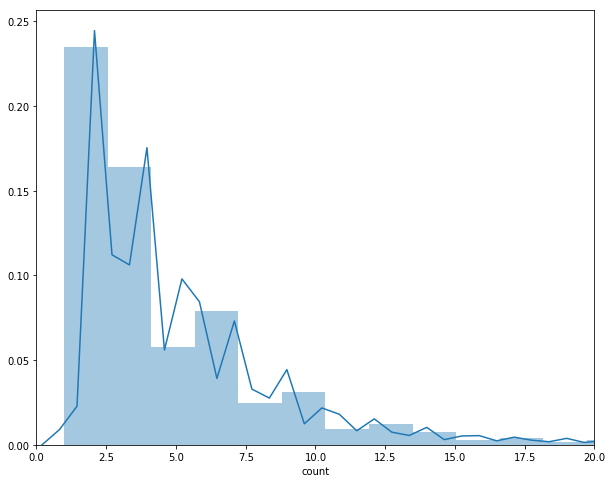

In [95]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(y_train)
ax.set_xlim(0, 20)

In [99]:
!pip install pdpbox

  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690734 sha256=4fa8956575b1eb6793028cde72c7342412a154ed56bfc0fb52c5a673f81794ff
  Stored in directory: C:\Users\btros\AppData\Local\pip\Cache\wheels\7d\08\51\63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [104]:
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.rcParams['figure.dpi'] = 150

feature = 'part_of_day'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2b40f2eb588>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2b410fc2388>})

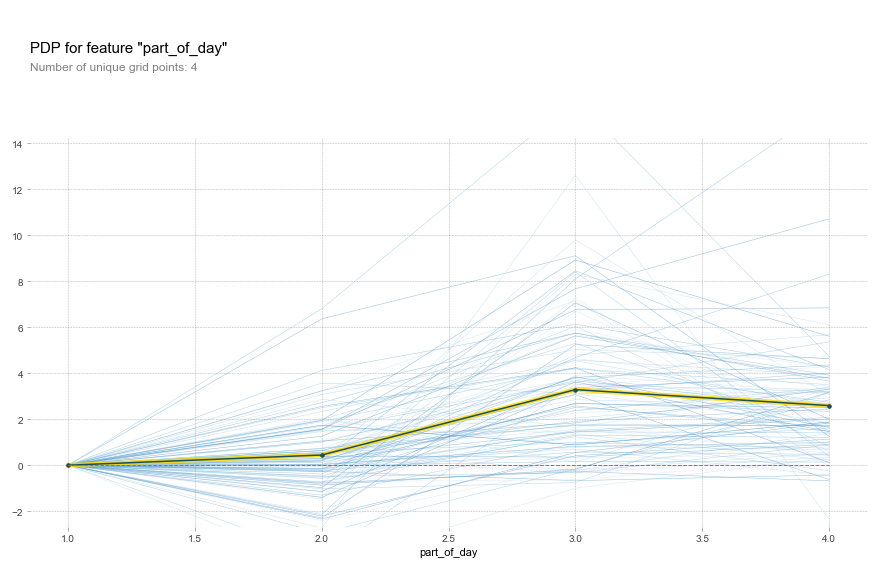

In [105]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)

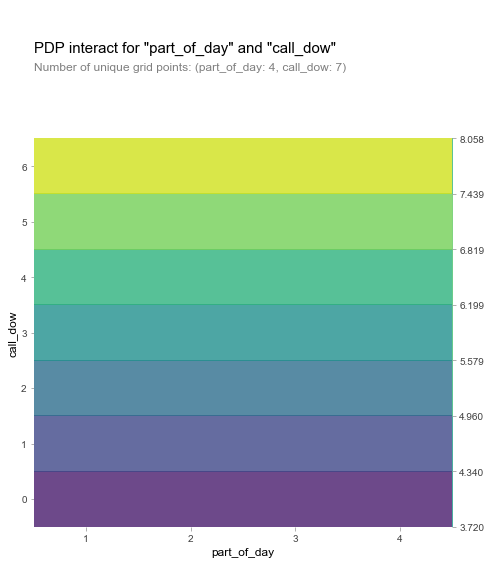

In [119]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['part_of_day', 'call_dow']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# Shaply Plots

In [110]:
!pip install shap

In [126]:
X_val.iloc[1]

call_year      2018.0
call_month        8.0
call_day          1.0
call_dow          2.0
call_week        31.0
part_of_day       1.0
lat_grid          1.0
lon_grid          4.0
Name: 226704, dtype: float64

In [128]:
import shap
import random as rd

row=X_val.iloc[1]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

MemoryError: 